In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
import time
from PIL import ImageOps, Image
from typing import Tuple, Dict, Callable, Optional, Union, List
from datetime import datetime
import json
import cv2
from src.utils.data_localisation import is_kaggle,is_notebook
from src.utils.seed import set_seed
from src.utils.data_preparation import pad_image_if_needed, get_random_crop_coords, crop_image, crop_image_and_masks

c:\Users\Marta\miniconda3\envs\capstone_5\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Nie można odnaleźć określonej procedury'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class CFG:
    experiment_id           = 'LG36'
    model_name              = 'UNet'
    train_bs                = 8
    valid_bs                = 8
    crop_size               = (64 , 64)
    num_crops               = 1
    epochs                  = 2
    lr                      = 0.0001
    data_train_test_split   = 0.9
    data_train_val_split    = 0.8
    device                  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    mask_train              = False
    cancerous_train         = True
    hard_to_classify_train  = True
    inflammatory_train      = True
    stroma_train            = True
    
enabled_masks = {
    "cancerous": CFG.cancerous_train,
    "hard_to_classify": CFG.hard_to_classify_train,
    "inflammatory": CFG.inflammatory_train,
    "stroma": CFG.stroma_train
}
class_names = [name for name, enabled in enabled_masks.items() if enabled]
num_masks = sum([CFG.mask_train, CFG.cancerous_train, CFG.hard_to_classify_train, CFG.inflammatory_train, CFG.stroma_train])

In [3]:
if is_kaggle():
    dataset_path = '/kaggle/input/'
    reports_dir = '/kaggle/working/'
    models_dir = '/kaggle/working/'
else:
    base_dir = os.path.dirname(os.getcwd())

    if is_notebook():
        dataset_path = os.path.join(base_dir, 'data')        
        reports_dir = os.path.join(base_dir, 'reports')
        models_dir = os.path.join(base_dir, 'models')
        
    else:
        dataset_path = os.path.join(base_dir, 'capstrone_group5','src', 'data')
        reports_dir = os.path.join(base_dir, 'capstone_group5', 'src', 'reports')
        models_dir = os.path.join(base_dir, 'capstone_group5', 'src', 'models')

os.makedirs(reports_dir, exist_ok=True)
models_dir = os.path.join(base_dir, 'capstone_group5', 'src', 'models') if not is_notebook() else os.path.join(base_dir, 'models')

In [4]:
if torch.cuda.is_available():
    print(f"Current device index: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available. Check your PyTorch installation and GPU drivers.")
allocated_memory = torch.cuda.memory_allocated()
GPU_used = round(allocated_memory / 1024**3, 2)

CUDA is not available. Check your PyTorch installation and GPU drivers.


In [5]:
print(f"Number of active masks is {num_masks}.")
print(f"Dataset path: {dataset_path}")
print(f"Dataset path: {reports_dir}")
print(f"Dataset path: {models_dir}")
print(f"CUDA available: {torch.cuda.is_available()}\n")
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"GPU Memory Allocated: {allocated_memory / 1024**3:.2f} GB")

Number of active masks is 4.
Dataset path: c:\Users\Marta\Desktop\capstone_group5\src\data
Dataset path: c:\Users\Marta\Desktop\capstone_group5\src\reports
Dataset path: c:\Users\Marta\Desktop\capstone_group5\src\models
CUDA available: False

Number of GPUs: 0
GPU Memory Allocated: 0.00 GB


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

mask_config = {
    "cancerous": CFG.cancerous_train,
    "hard_to_classify": CFG.hard_to_classify_train,
    "inflammatory": CFG.inflammatory_train,
    "stroma": CFG.stroma_train,
    "mask": CFG.mask_train
}

In [7]:
class HistopathologyDataset(Dataset):
    def __init__(self, root_dir:str, mask_config:Dict[str,bool], transform:Optional[Callable[[Image.Image], Image.Image]]=False):
        """
        Args:
            root_dir (str): Katalog z obrazami i maskami.
            mask_config (dict): Słownik konfiguracji masek, gdzie klucze to nazwy masek, a wartości to True/False.
            transform (callable, optional): Transformacje do zastosowania na obrazie i maskach.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.mask_config = mask_config
        self.crop_size = CFG.crop_size
        self.num_crops = CFG.num_crops
        
        self.image_paths = []
        self.mask_paths = {key: [] for key in mask_config.keys() if mask_config[key]}

        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith("ROI.png"):
                    image_path = os.path.join(subdir, file)
                    mask_base_path = image_path.replace("ROI.png", "")
                    
                    for mask_type in self.mask_config.keys():
                        if self.mask_config[mask_type]:
                            mask_path = mask_base_path + mask_type.upper() + ".png"
                            self.mask_paths[mask_type].append(mask_path)
                    
                    self.image_paths.append(image_path)

    def __len__(self) -> int:
        
        return len(self.image_paths) * self.num_crops

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Image.Image]]:
        
        image_idx = idx // self.num_crops
        crop_idx = idx % self.num_crops

        image = Image.open(self.image_paths[image_idx]).convert("RGB")
            
        masks = {}
        for mask_type in self.mask_config.keys():
            if self.mask_config.get(mask_type, False):
                mask_path = self.mask_paths[mask_type][image_idx]
                mask = Image.open(mask_path).convert("L")
                masks[mask_type] = mask
        
        crop_coords = get_random_crop_coords(image.size, self.crop_size)
        cropped_image, cropped_masks = crop_image_and_masks(image, masks, crop_coords)
    
        if self.transform:                
            cropped_image = self.transform(cropped_image)
        
            mask_transforms = transforms.Compose([transforms.ToTensor()])
            cropped_masks = {
                key: (mask_transforms(mask) > 0).float() for key, mask in cropped_masks.items()
            }
          
            cropped_masks = dict(sorted(cropped_masks.items()))
        
        return cropped_image, cropped_masks


In [8]:
set_seed(42)

In [9]:
### train vs test
dataset = HistopathologyDataset(root_dir=dataset_path, mask_config=mask_config, transform=transform)
train_val_size = int(CFG.data_train_test_split* len(dataset))
test_size = len(dataset) - train_val_size
trainval_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_val_size, test_size])

train_loader = DataLoader(trainval_dataset, batch_size=CFG.train_bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CFG.valid_bs, shuffle=False)

## train vs val
train_size = int(CFG.data_train_val_split* len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.valid_bs, shuffle=False)

In [10]:
print(f"Dataset path is: {dataset_path}")
print(f"Number of elements in the dataset: {len(dataset)}")
print(10*"=","TRENING VS. TEST", 10*"=")
print(f"Number of elements in dataset train: {train_size}")
print(f"Number of elements in dataset val: {val_size}")
print(f"Number of elements in dataset test: {test_size}")
print(f"Percentage split (train vs. test) of the dataset is : {CFG.data_train_test_split*100}%.")
print(f"Percentage split (train vs. val) of the dataset is : {CFG.data_train_val_split*100}%.")
print(10*"=","MISSING DATA CHECK", 10*"=")

mask_types = {
    "Cancerous": {"cancerous": True},
    "Hard to classify": {"hard_to_classify": True},
    "Inflammatory": {"inflammatory": True},
    "Stroma": {"stroma": True},
}

for mask_name, mask_config in mask_types.items():
    sample_count = len(HistopathologyDataset(root_dir=dataset_path, mask_config=mask_config, transform=transform))
    print(f"{mask_name} samples: {sample_count}.")

Dataset path is: c:\Users\Marta\Desktop\capstone_group5\src\data
Number of elements in the dataset: 673
========== TRENING VS. TEST ==========
Number of elements in dataset train: 484
Number of elements in dataset val: 121
Number of elements in dataset test: 68
Percentage split (train vs. test) of the dataset is : 90.0%.
Percentage split (train vs. val) of the dataset is : 80.0%.
========== MISSING DATA CHECK ==========
Cancerous samples: 673.
Hard to classify samples: 673.
Inflammatory samples: 673.
Stroma samples: 673.


In [11]:
def split_dataset(dataset, split_ratio, batch_size, shuffle=True):
    split_size = int(split_ratio * len(dataset))
    remainder_size = len(dataset) - split_size
    split_dataset, remainder_dataset = torch.utils.data.random_split(dataset, [split_size, remainder_size])
    split_loader = DataLoader(split_dataset, batch_size=batch_size, shuffle=shuffle)
    remainder_loader = DataLoader(remainder_dataset, batch_size=batch_size, shuffle=False)
    return split_loader, remainder_loader, split_size, remainder_size

# Full dataset
dataset = HistopathologyDataset(root_dir=dataset_path, mask_config=mask_config, transform=transform)

# Train vs Test Split
trainval_loader, test_loader, train_val_size, test_size = split_dataset(dataset, CFG.data_train_test_split, CFG.valid_bs)

# Train vs Val Split (on the train/validation portion from the previous split)
train_loader, val_loader, train_size, val_size = split_dataset(trainval_loader.dataset, CFG.data_train_val_split, CFG.train_bs)


 REPRESENTATION OF EMPTY PICTURES IN EACH CLASS

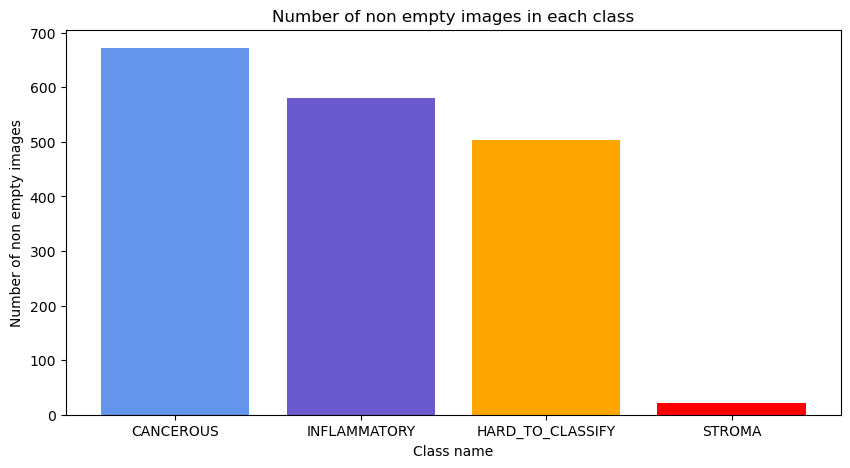

Class name: CANCEROUS,   Number of non empty images: 672 out of 675
Class name: INFLAMMATORY,   Number of non empty images: 580 out of 675
Class name: HARD_TO_CLASSIFY,   Number of non empty images: 503 out of 675
Class name: STROMA,   Number of non empty images: 21 out of 675


In [12]:
# Classes to analyse
classes = ["CANCEROUS", "INFLAMMATORY", "HARD_TO_CLASSIFY", "STROMA"]

# Dictionary for saving number of non empty images
non_empty_images = {class_name: 0 for class_name in classes}

# Going through dirs and subdirs
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".png"):
            for class_name in classes:
                if file.endswith(f"{class_name}.png"):
                    image_path = os.path.join(root, file)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    
                    # Convert image to binary
                    binary_image = (image > 0).astype(np.uint8)
                    
                    # Check if image has at least one pixel=1
                    if np.any(binary_image == 1):
                        non_empty_images[class_name] += 1

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(non_empty_images.keys(), non_empty_images.values(), color=['cornflowerblue', 'slateblue', 'orange', 'red'])
plt.xlabel('Class name')
plt.ylabel('Number of non empty images')
plt.title('Number of non empty images in each class')
plt.show()

for key, value in non_empty_images.items():
    print(f'Class name: {key},   Number of non empty images: {value} out of 675')

In [13]:
IR_with_stroma_class = non_empty_images['CANCEROUS']/non_empty_images['STROMA']
IR_without_stroma_class = non_empty_images['CANCEROUS']/non_empty_images['HARD_TO_CLASSIFY']
print(f'Imbalance Ratio for dataset including STROMA class: {IR_with_stroma_class}' )
print(f'Imbalance Ratio for dataset after excluding STROMA class: {IR_without_stroma_class:.2f}')

Imbalance Ratio for dataset including STROMA class: 32.0
Imbalance Ratio for dataset after excluding STROMA class: 1.34


CONCLUSION:
- Only 21 out of 675 images representing STROMA class is non empty. 
- Including images from STROMA class dataset is highly imbalanced. 
- After excluding images representing STROMA class from analysis Imbalance Ratio for the dataset dropped from 32 to 1.34.